### Train classification model

In [1]:
import os, sys
import scipy.misc
from glob import glob
import numpy as np
import random 
import shutil 
import keras
import time
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation,Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.optimizers import Adam
from keras import optimizers
import pickle

ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR)
import helpers

data_name = "cxr_normalvcovid+g1g2" 
DATASET_PATH = os.path.join(ROOT_DIR, "dataset", data_name ,"train")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset", data_name ,"test")
EXPERIMENT_NAME = data_name 

if not os.path.exists(os.path.join(ROOT_DIR, "models")):
    os.mkdir(os.path.join(ROOT_DIR, "models"))

LOG_PATH = os.path.join(ROOT_DIR, "models", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

Using TensorFlow backend.
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasib/anaconda

In [2]:
# Helpers
def save_obj(obj, name):
    with open('{}'.format(LOG_PATH) + "/"+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('{}'.format(LOG_PATH) + name + '.pkl', 'rb') as f:
        return pickle.load(f)


def vgg():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(256, 256, 3))
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    for layer in base_model.layers:
        layer.trainable=True
        
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer and loss
    optim = optimizers.Adadelta(lr=0.001) #Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model

model = None
model = vgg()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_____________________________________________________

In [3]:
# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(LOG_PATH, EXPERIMENT_NAME), monitor='val_loss', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, mode='min'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=15, mode='min', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(LOG_PATH))
]

In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


#---------------------------
# cxr
# 0 - cov
# 1 - normal
# 2 - pneu
#---------------------------
# cxr_normalvcovid
# 0 - cov19
# 1 - normal
#---------------------------
# cxr_pneucovid
# 0 - cov19
# 1 - pneu
#---------------------------
#class_weight = {0: 0.9, 1: 0.1}

def processing_func(img):
    # do sth
    
    
    return img


# preprocessing_function=None

TRAINING_DIR = DATASET_PATH
training_datagen = ImageDataGenerator(
        rescale = 1./255)
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #fill_mode='nearest')

VALIDATION_DIR = TEST_DATASET_PATH
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size = 16
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size = 16
)

Found 38012 images belonging to 2 classes.
Found 4181 images belonging to 2 classes.


In [5]:
x, y = next(iter(train_generator))
x.shape, y.shape

((16, 256, 256, 3), (16, 2))

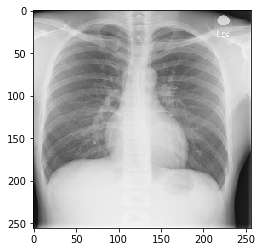

In [6]:
plt.imshow(x[0])

In [7]:
y[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
start_time = time.time()


history = model.fit_generator(train_generator, 
                    epochs=200, validation_data = validation_generator, 
                    verbose = 1,
                    class_weight=None,
                    callbacks=callbacks, shuffle=True)


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
2376/2376 [==============================] - 328s 138ms/step - loss: 0.1618 - accuracy: 0.9324 - val_loss: 0.0335 - val_accuracy: 0.9890
Epoch 2/200
2376/2376 [==============================] - 335s 141ms/step - loss: 0.0276 - accuracy: 0.9946 - val_loss: 0.0039 - val_accuracy: 0.9897
Epoch 3/200
2376/2376 [==============================] - 343s 144ms/step - loss: 0.0226 - accuracy: 0.9953 - val_loss: 0.0094 - val_accuracy: 0.9900
Epoch 4/200
2376/2376 [==============================] - 345s 145ms/step - loss: 0.0193 - accuracy: 0.9954 - val_loss: 0.0104 - val_accuracy: 0.9907
Epoch 5/200
2376/2376 [==============================] - 345s 145ms/step - loss: 0.0169 - accuracy: 0.9957 - val_loss: 0.0013 - val_accuracy: 0.9914
Epoch 6/200
2376/2376 [==============================] - 345s 145ms/step - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0332 - val_accuracy: 0.9902
Epoch 7/200
2376/2376 [==============================] - 3

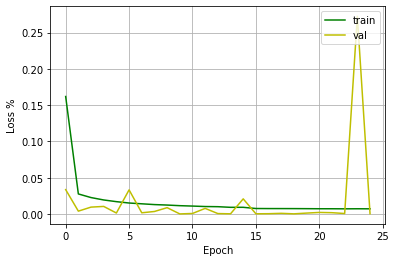

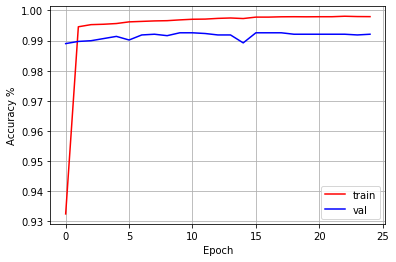

Done training and logging!


In [9]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()

plot_loss_accu(history)
print("Done training and logging!")

In [10]:
from keras.models import load_model

model = None
model = load_model("{}/{}.h5".format(LOG_PATH, EXPERIMENT_NAME), compile = False)
#model.summary()

In [11]:
# Get test data

#---------------------------
# cxr
# 0 - cov
# 1 - normal
# 2 - pneu
# test_all
#---------------------------
# cxr_normalvcovid
# 0 - cov19
# 1 - normal
#test_nvc
#---------------------------
# cxr_pneucovid
# 0 - cov19
# 1 - pneu
# test_pvc
#---------------------------


dest_path = os.path.join(ROOT_DIR, "dataset/numpy/")

# test_nvc or test_pvc, change manually!
x_test = np.load("{}/test_nvc.npy".format(dest_path))
y_test = np.load("{}/test_nvc_labels.npy".format(dest_path))
x_test.shape, y_test.shape

((4181, 256, 256, 3), (4181, 2))

In [12]:
# Standardize
x_test = x_test.astype('float32')
x_test /= 255

In [13]:
# Make predictions using trained model
y_pred = model.predict(x_test, verbose=1)
print("Predictions: ", y_pred.shape)


y_pred_inv = []

for y in y_pred:
    y = np.flip(y, 0 )
    y_pred_inv.append(y)

y_pred = np.array(y_pred_inv)
print("New: ", y_pred.shape)


# GTs
#y_test_flat = y_test

#y_pred_flat = []
#for pred in y_pred:
#    if pred > 0.5:
#        y_pred_flat.append(1)
#    else:
#        y_pred_flat.append(0)
#y_pred_flat = np.array(y_pred_flat)


# Convert ground truth to column values
y_test_flat = np.argmax(y_test, axis=1)
print("After flattening ground truth: ", y_test_flat.shape)


# Get labels from predictions
y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) 
print("Binarize probability values: ", y_pred_flat.shape)

assert y_pred_flat.shape == y_test_flat.shape, "Shape mismatch!"

4181/4181 [==============================] - 12s 3ms/step
Predictions:  (4181, 2)
New:  (4181, 2)
After flattening ground truth:  (4181,)
Binarize probability values:  (4181,)


In [14]:
# Sanity check

print(y_test.shape, y_test_flat.shape, y_pred.shape, y_pred_flat.shape)

(4181, 2) (4181,) (4181, 2) (4181,)


In [15]:
y_test_flat_ = []

for y in y_test_flat:
    if y==0:
        y_test_flat_.append(1)
    else:
        y_test_flat_.append(0)
        
        
#y_pred_flat_ = []

#for y in y_pred_flat:
#    if y==0:
#        y_pred_flat_.append(1)
#    else:
#        y_pred_flat_.append(0)
        
        
y_test_flat = np.array(y_test_flat_)
#y_pred_flat = np.array(y_pred_flat_)

print(y_test_flat.shape, y_pred_flat.shape)

y_test = keras.utils.to_categorical(y_test_flat, 2)
#y_pred = keras.utils.to_categorical(y_pred_flat, 2)
print(y_test.shape, y_pred.shape)

(4181,) (4181,)
(4181, 2) (4181, 2)


In [16]:
vals = []

for yhat, y in zip(y_pred_inv, y_test):
    if y[1] == 1:
        vals.append(yhat[1])
    
vals = np.array(vals)
vals.shape

(46,)

In [17]:
vals[:10]

array([0.9614806 , 0.99879044, 0.9192056 , 0.6086659 , 0.19092539,
       0.9805602 , 0.7712002 , 0.34872812, 0.9273659 , 0.01407559],
      dtype=float32)

In [18]:
y = [i for i in range(46)]

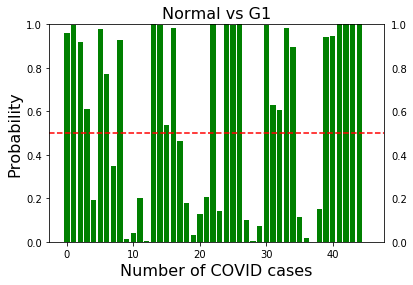

In [19]:
#plt.hist(vals, bins=46, color='c')
x = vals
plt.bar(y, x, color='g')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title("Normal vs G1", size=16)
plt.xlabel("Number of COVID cases", size=16)
plt.ylim([0.0, 1.0])
#plt.grid(True)
plt.ylabel("Probability", size=16)
plt.tick_params(labelright=True)
plt.savefig("{}/{}.pdf".format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
plt.show()

In [20]:
np.count_nonzero(y_test_flat == 1)

46

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)

Accuracy : 97.60822769672328


In [22]:
# Classification report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)
target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

[[4055   80]
 [  20   26]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4135
           1       0.25      0.57      0.34        46

    accuracy                           0.98      4181
   macro avg       0.62      0.77      0.66      4181
weighted avg       0.99      0.98      0.98      4181



In [23]:
tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()
tn, fp, fn, tp

(4055, 80, 20, 26)

In [24]:
sensitivity = tp /(tp + fn)
sensitivity * 100

56.52173913043478

In [25]:
tp+fn

46

In [26]:
# Kappa
from sklearn.metrics import cohen_kappa_score

kp = cohen_kappa_score(y_test_flat, y_pred_flat)
print("Kappa :", kp)

Kappa : 0.331852467399642


In [27]:
from sklearn.metrics import brier_score_loss

br = brier_score_loss(y_test_flat, y_pred_flat, pos_label=1)
print("Brier loss :", br)

Brier loss : 0.02391772303276728


In [28]:
# Average precision

from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, y_pred) * 100
print("Average precision :", ap)

# 75.81,

Average precision : 71.92374178874572


In [29]:
# Sensitivity and Specificity

#cm = confusion_matrix(y_pred=y_pred_flat, y_true=y_test_flat)
#total=sum(sum(cm))

##sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
#print('Sensitivity : ', sensitivity*100 )

#Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
#print('Specificity : ', Specificity*100 )

In [30]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

Area under ROC curve :  91.29803900951579


In [31]:
from sklearn.metrics import f1_score
F1_score = f1_score(y_test_flat, y_pred_flat, labels=None, average='binary', sample_weight=None)
F1_score * 100

34.210526315789465

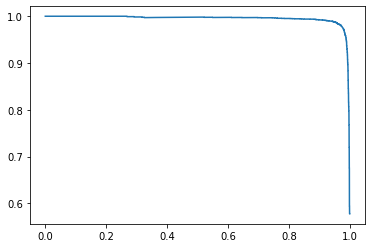

In [32]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# PR curve
y_true = y_test.ravel() 
y_preds = y_pred.ravel() 
precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
plt.figure(20)
plt.plot(recall,precision)

In [33]:
ascore = {}
ascore["recall"] = recall
ascore["precision"] = precision
save_obj(ascore, "{}_PR_curve".format(data_name))

Area under the ROC curve for positive class: 0.912980390095158


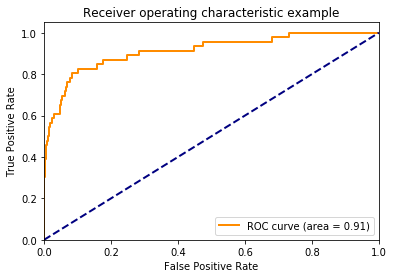

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
cls = 1 # class name
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(roc_auc)
print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2 # line width
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Save AUCROC for plotting
ascore = {}
ascore["fpr"] = fpr[cls]
ascore["tpr"] = tpr[cls]
ascore["roc_auc"] = roc_auc[cls]
save_obj(ascore, data_name)